In [2]:
import torch
from sdot.sdot_solve import sdot_solve

In [3]:
targets=[
    [-3, -3],
    [-2, -2],
    [-2.3,-3.5],
    [-3,-2],
    [-3.3, -2.8],
    [-2.3, -1.8],
    [-2,0],
    [0, -2],
    [-2.2, -3.2], 
]

targets=torch.tensor(targets, dtype=torch.float32)

In [4]:
dual_weight, info_dict=sdot_solve(targets, ema_param=0.99, batch_size=1024, num_step=5000, lr=0.1)

100%|██████████| 5000/5000 [00:03<00:00, 1449.41it/s, mre_est=0.00484, L1_est=0.00171]  


In [5]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt

def plot_laguerre_cells(sites, weights):
    """
    Plots the Laguerre cells corresponding to a given set of points and dual weights.

    The Laguerre cell for a site p_i is defined as the set of all points x
    such that ||x - p_i||^2 - w_i <= ||x - p_j||^2 - w_j for all j != i.
    
    Args:
        sites (np.ndarray): A NumPy array of shape (N, 2) representing the
                            coordinates of N sites in 2D space.
        weights (np.ndarray): A NumPy array of shape (N,) representing the
                              dual weights for each site.
    """
    # Validate input array dimensions
    if sites.shape[1] != 2:
        print("The sites array must have a shape of (N, 2).")
        return
    if sites.shape[0] != weights.shape[0]:
        print("The number of sites and weights must match.")
        return

    # Define the plotting grid to ensure all sites are in view
    # x_min, x_max = sites[:, 0].min() - 1, sites[:, 0].max() + 1
    # y_min, y_max = sites[:, 1].min() - 1, sites[:, 1].max() + 1
    x_min, x_max=-8, 8
    y_min, y_max=-8, 8
    
    # Create a dense grid
    grid_res = 500  # Grid resolution
    x_grid = np.linspace(x_min, x_max, grid_res)
    y_grid = np.linspace(y_min, y_max, grid_res)
    xx, yy = np.meshgrid(x_grid, y_grid)
    
    # Flatten the grid points for efficient computation
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

    # Efficiently compute the "power" or "energy" for each grid point relative to all sites
    # Power P = ||x - p_i||^2 - w_i
    # np.sum((grid_points[:, np.newaxis, :] - sites)**2, axis=2) calculates the squared
    # Euclidean distance from all grid points to all sites.
    # The result is then weighted by the dual weights.
    powers = np.sum((grid_points[:, np.newaxis, :] - sites)**2, axis=2) - weights
    
    # Find the index of the site with the minimum power for each grid point
    cell_indices = np.argmin(powers, axis=1)

    # Reshape the 1D index array back to the grid shape
    cell_grid = cell_indices.reshape(xx.shape)

    # Plot the results
    plt.figure(figsize=(8, 8))
    plt.imshow(cell_grid, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='viridis', alpha=0.7)
    
    # Plot the original sites on top
    plt.scatter(sites[:, 0], sites[:, 1], c='red', s=100, marker='o', edgecolors='black', label='Target points')
    
    # Annotate each site with its index
    for i, p in enumerate(sites):
        plt.text(p[0] + 0.05, p[1] + 0.05, f'P{i}', fontsize=12, weight='bold')

    plt.title('Laguerre Cells', fontsize=16, pad=20)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal') # Ensure the aspect ratio is equal
    plt.axis('off')
    plt.savefig('laguerre_cells.pdf', bbox_inches='tight')
    plt.show()



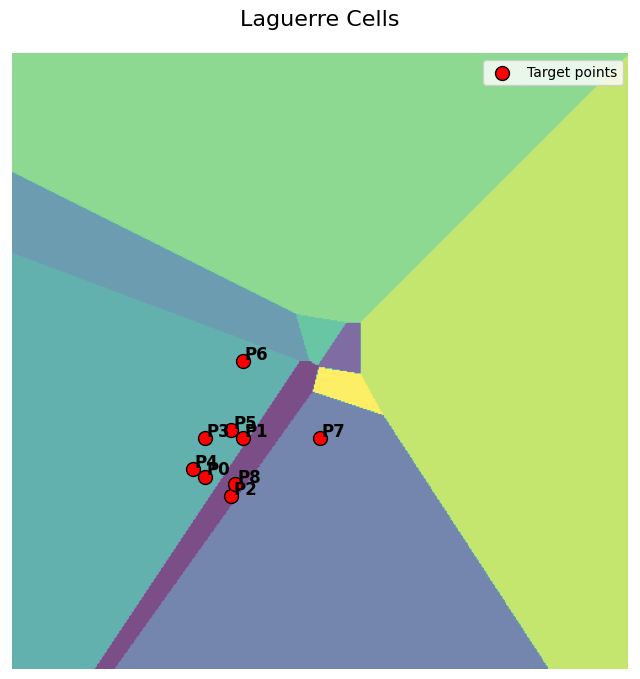

In [6]:
# Call the function to plot the Laguerre cells
plot_laguerre_cells(targets.numpy(), dual_weight.numpy())



In [7]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_laguerre_cells_with_density(sites, weights, x_min=-4, x_max = 4, y_min= -4, y_max= 4):
    """
    Plots the Laguerre cells and a 2D normal density function on the same figure.

    Args:
        sites (np.ndarray): A NumPy array of shape (N, 2) for Laguerre sites.
        weights (np.ndarray): A NumPy array of shape (N,) for dual weights.
        mu (list or np.ndarray): Mean vector [mu_x, mu_y] for the normal distribution.
        sigma (list or np.ndarray): Covariance matrix for the normal distribution.
    """
    # Validate input array dimensions
    if sites.shape[1] != 2:
        print("The sites array must have a shape of (N, 2).")
        return
    if sites.shape[0] != weights.shape[0]:
        print("The number of sites and weights must match.")
        return

    # Create a single figure and axes for both plots
    fig, ax = plt.subplots(figsize=(4, 4))

    # Define the plotting grid
    
    
    # ------------------ Plotting the Laguerre Cells ------------------
    # Create a dense grid for plotting the cells
    grid_res = 500
    x_grid = np.linspace(x_min, x_max, grid_res)
    y_grid = np.linspace(y_min, y_max, grid_res)
    xx_cell, yy_cell = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xx_cell.ravel(), yy_cell.ravel()]).T

    # Compute the "power" for each grid point relative to all sites
    powers = np.sum((grid_points[:, np.newaxis, :] - sites)**2, axis=2) - weights
    cell_indices = np.argmin(powers, axis=1)
    cell_grid = cell_indices.reshape(xx_cell.shape)

    # Use the same colormap for cells and sites
    cmap = plt.get_cmap('Paired')
    ax.imshow(cell_grid, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap=cmap, alpha=1, interpolation_stage='rgba')
    print(cell_grid)

    # ------------------ Plotting the Sites ------------------
# Create a list of colors for the sites using their indices
    num_sites = len(sites)
    site_indices = np.arange(num_sites)
    site_colors = cmap(site_indices / (num_sites - 1))
    
    # Plot the original sites on top of both layers
    ax.scatter(sites[:, 0], sites[:, 1], c=site_colors, s=100, marker='o', edgecolors='black', label='Target points', zorder=3)
    
    # ------------------ Final Plot Settings ------------------
    ax.grid(False)
    ax.axis('equal')# Call the function to plot the Laguerre cells

    ax.set_xlim(x_min, x_max)
    plt.savefig('laguerre_cells.pdf', bbox_inches='tight')
    plt.show()


[[4 4 4 ... 7 7 7]
 [4 4 4 ... 7 7 7]
 [4 4 4 ... 7 7 7]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


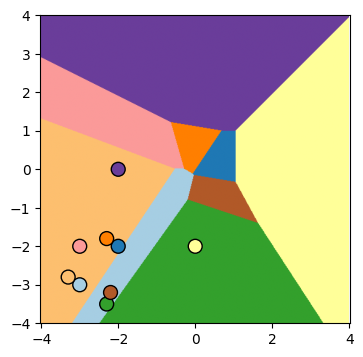

In [8]:
plot_laguerre_cells_with_density(targets.numpy(), dual_weight.numpy())


In [9]:
def plot_normal_density(sites, x_min=-4, x_max = 4, y_min= -4, y_max= 4):
    fig, ax = plt.subplots(figsize=(4, 4))
    # ------------------ Plotting the 2D Normal Density Function ------------------
    # Create a grid for the normal density plot
    x_norm = np.linspace(x_min, x_max, 100)
    y_norm = np.linspace(y_min, y_max, 100)
    xx_norm, yy_norm = np.meshgrid(x_norm, y_norm)
    pos = np.dstack((xx_norm, yy_norm))

    # Define the normal distribution
    rv = multivariate_normal(mean=[0,0], cov=[[1,0], [0,1]])

    # Calculate the PDF on the grid
    z = rv.pdf(pos)

    # Plot the density using pcolormesh on the same axes
    norm_z = (z - z.min()) / (z.max() - z.min())

    
    # ax.imshow(cell_grid, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap=cmap, alpha=1)
    plt.imshow(z, extent=[x_min, x_max, y_min, y_max], origin='lower', zorder=1, cmap='gray_r')

    num_sites = len(sites)
    site_indices = np.arange(num_sites)
    cmap = plt.get_cmap('Paired')
    site_colors = cmap(site_indices / (num_sites - 1))
    
    # Plot the original sites on top of both layers
    plt.scatter(sites[:, 0], sites[:, 1], c=site_colors, s=100, marker='o', edgecolors='black', label='Target points', zorder=3)
    # ax.pcolormesh(xx_norm, yy_norm, z, cmap='gray_r', alpha=0.8, zorder=1) # zorder to control layering
    plt.savefig('normal_density.pdf', bbox_inches='tight')


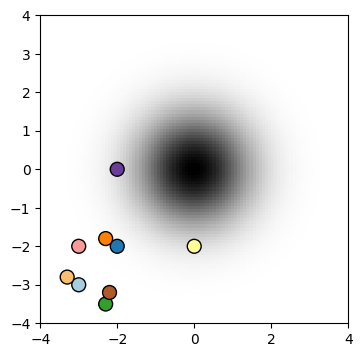

In [10]:
plot_normal_density(targets.numpy())
